In [1]:
%matplotlib inline 
# above line allows for showing plots in a cell easily
import matplotlib # the main plotting library
#matplotlib.style.use('ggplot')
import numpy as np # allows for arrays
import matplotlib.pyplot as plt # getting specific plotting functions
import urllib # URL import functions
import pandas as pd # nice data utilities

In [2]:
q=pd.read_table('./data/log_1.csv', header=0,sep=',',names=['t','tm','s']);

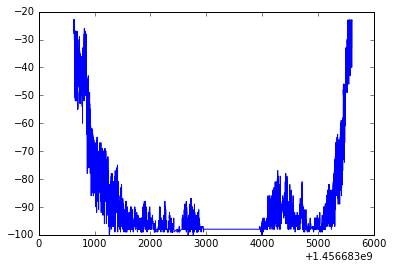

In [3]:
plt.plot(q.t,q.s); 

Below is from https://ocefpaf.github.io/python4oceanographers/blog/2014/05/05/folium/ ...

In [4]:
#fname = './data/DHO.kml'
fname = './data/DHO_cwv_GoogleEarth.kml'

In [5]:
a=open(fname).read();

In [6]:
from xml.dom.minidom import parseString

In [7]:
dom=parseString(a)

In [8]:
latitudes=[]
longitudes=[]


for d in dom.getElementsByTagName('coordinates'):
    coords=d.firstChild.data.split(',')
    longitudes.append(float(coords[0]))
    latitudes.append(float(coords[1]))

In [9]:
timeList=dom.getElementsByTagName('when')
coordList=dom.getElementsByTagName('gx:coord')
placeList=dom.getElementsByTagName('TimeStamp')
#print(timeList[0].toxml())
#print(len(reflist))
print(len(timeList))
print(len(coordList))
print(len(placeList))

821
801
20


I think this means: skip the 'when' items that have 'TimeStamp' associated with them. I.e., the first len(placeList) items. 

In [10]:
times=timeList[(len(placeList)+1):];coords=coordList[:(len(coordList)-1)]

In [11]:
print(times[0].toxml())
print(coords[0].toxml())
print(len(coords)); print(len(times))

<when>2016-02-28T18:22:17.000Z</when>
<gx:coord>-70.976616 43.15733 48.8</gx:coord>
800
800


Yes, this matches the file ... 

In [12]:
t=[]
for ts in times:
    #t.append(ts.firstChild.data.split('.')[0])
    t.append(ts.firstChild.data)

In [13]:
lat=[]
lon=[]
alt=[]
for c in coords:
    thisc = c.firstChild.data.split(' ')
    lat.append(float(thisc[0]))
    lon.append(float(thisc[1]))
    alt.append(float(thisc[2]))

In [14]:
t[222]

'2016-02-28T18:42:21.000Z'

In [15]:
import time
pattern='%Y-%m-%dT%H:%M:%S.000Z'
tGPS=[]
timeShift=18000 #GPS is 5 hours off, which is 18000 seconds
for ts in t:
    thisTime=int(time.mktime(time.strptime(ts, pattern)))-timeShift
    tGPS.append(thisTime)

In [16]:
tGPS[0]

1456683737

In [17]:
tLog=[]
for ts in q.t:
    tLog.append(int(ts))

In [18]:
len(tLog)

6850

In [19]:
# start with some metric

diffBest=(tLog[0])**4

# now go through and compare
diffs=[]
fl=[] # array of indices into tLog for the closest time to any given tGPS time
mins=[]

for i in range(0,len(tGPS)):
    tG=tGPS[i]
    diffs=[]
    for j in range(0,len(tLog)):
        diff=(tLog[j]-tG)**2
        diffs.append(diff)
    myd=np.asarray(diffs);
    mind=min(diffs)
    ta=np.where(myd == myd.min())
    mins.append(mind)
    fl.append(ta[0][0])

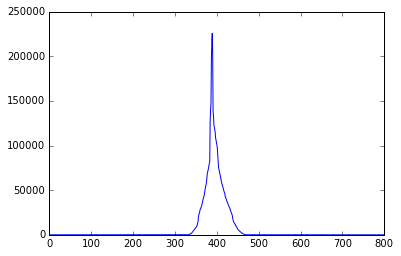

In [20]:
plt.plot(mins)

(0, 50)

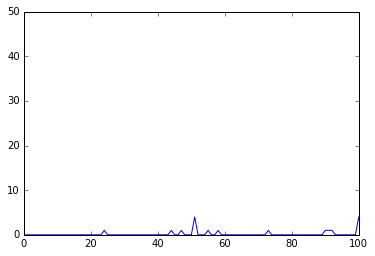

In [21]:
plt.plot(mins);plt.xlim(0,100);plt.ylim(0,50)

Interpretation: when the minimum difference in time is greater than 0 seconds, this probably means that there was no data logged at that GPS location. 

So, when constructing combined file, assume that if time difference is greater than 1, no logging occurred.

In [22]:
# now go through and compare
fl=[] # array of indices into tLog for the closest time to any given tGPS time
mins=[]
finalC=[]

for i in range(0,len(tGPS)):
    tG=tGPS[i]
    la=lat[i]
    lo=lon[i]
    diffs=[]
    # generate differences array
    for j in range(0,len(tLog)):
        diff=(tLog[j]-tG)**2
        diffs.append(diff)
    # find the minimum time difference
    myd=np.asarray(diffs);
    mind=min(diffs)
    # if the minimum time difference == 0, then we had a signal
    if (mind<2):
        logIndex=np.where(myd == myd.min())[0][0] #index into the log file minim time
        finalC.append((tG,la,lo,q.s[logIndex]))
    else:
        finalC.append((tG,la,lo,-1000)) # some really low signal level

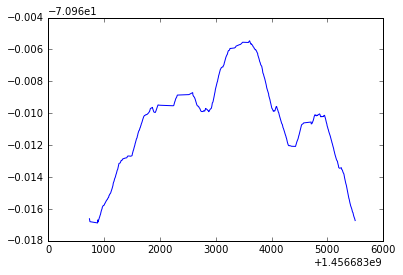

In [23]:
plt.plot(tGPS,lat)

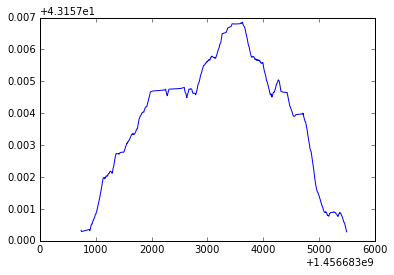

In [24]:
plt.plot(tGPS,lon)

In [25]:
finalC[0]

(1456683737, -70.976616, 43.15733, -43)

# Using Folium ...

http://folium.readthedocs.org/en/latest/quickstart.html#getting-started

http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_heatmap.ipynb

different tiles: https://leaflet-extras.github.io/leaflet-providers/preview/

In [26]:
# pip install folium
import folium

a=43.15733
b=-70.976616

#map_osm = folium.Map(location=[43.16050,-70.976616],zoom_start=15)
#map_osm = folium.Map(location=[43.16050,-70.976616],tiles='Stamen Terrain',zoom_start=15)
map_osm = folium.Map(location=[43.16050,-70.976616],tiles='MapQuestOpen Aerial',zoom_start=13)

kw = dict(opacity=1.0, weight=4)

for i in range(1,len(finalC)):
    rowBack=finalC[i-1]
    row=finalC[i]
    
    coordBack=(rowBack[2],rowBack[1])
    coord=(row[2],row[1])
    loc=[coordBack,coord]
    
    #signal strength 
    s=row[3]
    c='green'
    if (s<-85):
        c='blue' 
    if (s<-95):
        c='yellow'
    if (s<-200):
        c='red'
    l = folium.PolyLine(locations=loc, color=c, **kw)
     
    map_osm.add_children(l)

map_osm

```
Green: 'strong' 
Blue: 'fair'
Yellow: 'weak'
Red: 'no signal'
```

Notes: 

- even 'weak' signal might be sufficient when protocol involves repeated transmission
- signal may improve if care taken to arrange antenna vertically / less beer is consumed

# Write combined csv file

In [27]:
f = open('./data/out.csv','w')
for row in finalC:
    f.write(str(row[0]))
    f.write(",")
    f.write(str(row[2]))
    f.write(",")
    f.write(str(row[1]))
    f.write(",")
    f.write(str(row[3]))
    f.write("\n")
f.close() 

# Terrain map style

In [28]:
# pip install folium
import folium

a=43.15733
b=-70.976616

#map_osm = folium.Map(location=[43.16050,-70.976616],zoom_start=15)
map_osm = folium.Map(location=[43.16050,-70.976616],tiles='Stamen Terrain',zoom_start=15)
#map_osm = folium.Map(location=[43.16050,-70.976616],tiles='MapQuestOpen Aerial',zoom_start=15)

kw = dict(opacity=1.0, weight=4)

for i in range(1,len(finalC)):
    rowBack=finalC[i-1]
    row=finalC[i]
    
    coordBack=(rowBack[2],rowBack[1])
    coord=(row[2],row[1])
    loc=[coordBack,coord]
    
    #signal strength 
    s=row[3]
    c='green'
    if (s<-85):
        c='blue' 
    if (s<-95):
        c='yellow'
    if (s<-200):
        c='red'
    l = folium.PolyLine(locations=loc, color=c, **kw)
     
    map_osm.add_children(l)

map_osm

# OSM style

In [29]:
# pip install folium
import folium

a=43.15733
b=-70.976616

map_osm = folium.Map(location=[43.16050,-70.976616],zoom_start=15)
#map_osm = folium.Map(location=[43.16050,-70.976616],tiles='Stamen Terrain',zoom_start=15)
#map_osm = folium.Map(location=[43.16050,-70.976616],tiles='MapQuestOpen Aerial',zoom_start=15)
#map_osm = folium.Map(location=[43.16050,-70.976616],tiles='Stamen Watercolor',zoom_start=15)

kw = dict(opacity=1.0, weight=4)

for i in range(1,len(finalC)):
    rowBack=finalC[i-1]
    row=finalC[i]
    
    coordBack=(rowBack[2],rowBack[1])
    coord=(row[2],row[1])
    loc=[coordBack,coord]
    
    #signal strength 
    s=row[3]
    c='green'
    if (s<-85):
        c='blue' 
    if (s<-95):
        c='yellow'
    if (s<-200):
        c='red'
    l = folium.PolyLine(locations=loc, color=c, **kw)
     
    map_osm.add_children(l)

map_osm

In [41]:
p_dbm=23; p_watts = 10**((p_dbm - 30) / 10); p_watts

0.19952623149688797

arduino_awake: 25 mA

arduino_asleep: .4 mA

https://alanbmitchell.wordpress.com/2011/10/02/operate-arduino-for-year-from-batteries/